## Demo code for Gibbs sampling

This notebook illustrates Gibbs sampling for the Dirichlet process mixture, 
and compares to kernel density estimation, which is basically the same as kernel smoothing 
for regression. 


In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline


In [2]:
def gaussian_kernel(u, h):
    return (1./np.sqrt(2*np.pi*h**2)) * np.exp(-(u)**2/(2*h**2))

def kde_with_kernel(kernel, X, x, h):
    K = np.zeros(len(x)*len(X)).reshape(len(x), len(X))
    for j in np.arange(K.shape[1]):
        K[:,j] = kernel(x-X[j], h)
    fhat = np.mean(K, axis=1)
    return fhat


We read in the [Fiji earthquake data](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/quakes.html).

In [3]:
quakes = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/smoothing/fijiquakes.dat', sep='\s+')
quakes

,Obs.,lat,long,depth,mag,stations
0,1,-20.42,181.62,562,4.8,41
1,2,-20.62,181.03,650,4.2,15
2,3,-26.00,184.10,42,5.4,43
3,4,-17.97,181.66,626,4.1,19
4,5,-20.42,181.96,649,4.0,11
...,...,...,...,...,...,...
995,996,-25.93,179.54,470,4.4,22
996,997,-12.28,167.06,248,4.7,35
997,998,-20.13,184.20,244,4.5,34
998,999,-17.40,187.80,40,4.5,14


Text(0.5, 1.0, 'Kernel density estimate (frequentist)')

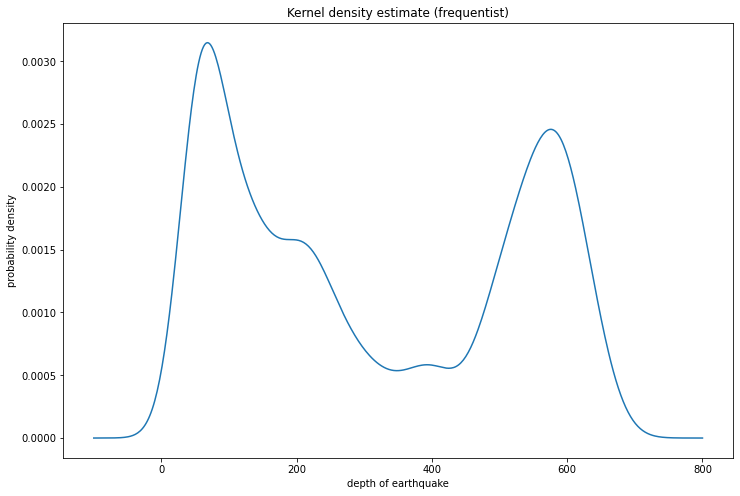

In [4]:
X = quakes['depth']
x = np.linspace(-100, 800, 500)

fhat = kde_with_kernel(gaussian_kernel, X, x, 30)
plt.figure(figsize=(12, 8))
plt.plot(x, fhat, label='kde')
plt.xlabel('depth of earthquake')
plt.ylabel('probability density')
plt.title('Kernel density estimate (frequentist)')
# plt.savefig('kde_baseline.pdf', bbox_inches='tight')
#_ = plt.legend()


In [5]:
def first_available_natural(c):
    for i in np.arange(len(c)):
        if not(i in c):
            return i
    return i+1

def gaussian_posterior_mean(xk, mu0, tau0, sigma):
    n = len(xk)
    se2 = sigma**2/n
    wn = 1 / (1 + se2/tau0**2)
    mu = wn * np.mean(xk) + (1-wn) * mu0
    tau = np.sqrt(se2 * wn)
    return mu, tau

def plot_density(x, c, mu0, tau0, sigma, step):
    from collections import Counter
    tables = Counter(c.data)
    xs = np.linspace(-100, 800, 500)
    clear_output(wait=True)
    plt.figure(figsize=(12,7))
    f = np.zeros(len(xs))
    for t in tables:
        xt = x[c==t]
        nt = len(xt)
        mut, taut = gaussian_posterior_mean(xt, mu0, tau0, sigma)
        ft =  (nt/(n + alpha)) * norm.pdf(xs, loc=mut, scale=np.sqrt(taut**2 + sigma**2))
        f = f + ft
        plt.plot(xs, ft, alpha=.2)
    f0 = (alpha/(n + alpha)) * norm.pdf(xs, loc=mu0, scale=sigma)
    plt.plot(xs, f, linewidth=2, color='gray')
    plt.scatter(x, np.zeros(len(x)), marker='|', linewidth=.5)
    plt.xlabel('earthquake depth (km)')
    plt.ylabel('probability density')
    plt.title('Gibbs step: %d; number of clusters: %d' % (step, len(tables)))
    filename = 'gibbs_%d_%d.pdf' % (step, len(tables))
    #plt.savefig(filename, bbox_inches='tight')
    plt.show()
    sleep(.01)

In [6]:
def run_gibbs_sampling():
    num_clusters = []
    for step in np.arange(gibbs_steps):
        clusters = np.unique(c.data)
        num_clusters.append(len(clusters))

        for i in np.arange(len(x)):
            xi = x[i]
            x.mask[i] = True
            c.mask[i] = True
            clusters = np.unique(c.data)
            clusters = np.append(clusters, first_available_natural(clusters))
            z = np.zeros(len(clusters))
            for k in np.arange(len(clusters)):
                xk = np.array(x[c==clusters[k]])
                nk = len(xk)
                if nk > 0:
                    mu, tau = gaussian_posterior_mean(xk, mu0, tau0, sigma)
                    z[k] = (nk / (n-1+alpha)) * norm.pdf(xi, loc=np.mean(xk), scale=30)
            z[-1] = (alpha / (n-1+alpha)) * norm.pdf(xi, loc=mu0, scale=tau0)
            weights = z/np.sum(z)
            k = np.random.choice(np.arange(len(weights)), size=1, p=weights)
            c[i] = clusters[k]
            x.mask[i] = False
            c.mask[i] = False

        if (step > 0) :
            plot_density(x, c, mu0, tau0, sigma, step)


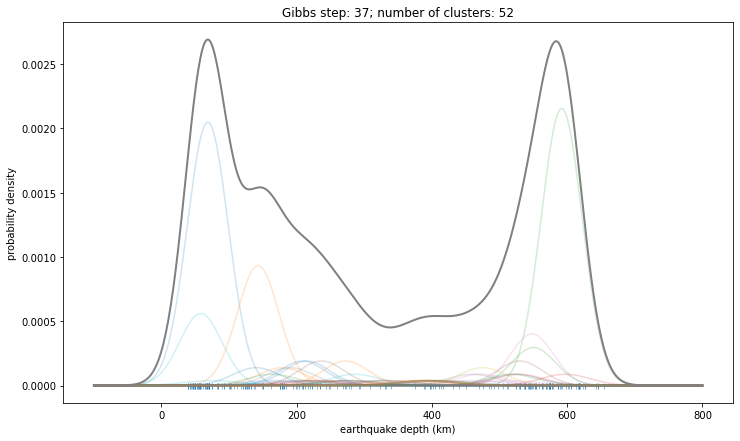

In [ ]:
sample_size = 200
sample = np.random.choice(np.arange(len(X)), size=sample_size)
x = np.array(X[sample])
c = np.random.choice(np.arange(10), size=len(x))
x = np.ma.array(x, mask=False)
c = np.ma.array(c, mask=False)

mu0 = np.mean(x)
sigma = 30
tau0 = 100
alpha = 50
n = len(x)
gibbs_steps = 100

run_gibbs_sampling()
